<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

05.08.21

Joining property sales dataset with local schools data (number of secondary schools in radius of 6 km, average weighted disadvantage pupils score, distance to the closest sec school, closest sec school disadv perc, english and math attainment). 
Joining property sales data with historic (3 mnths and 4 mnths) median prices per bedroom
RF on all of prop sales data (01/2018 to 02/2020)
Removing outliers (sales prices >=1.5m, bedrooms >5, comparison with historic median>100%)
Adding a feature (3 distances to London, Birmingham and Manchester locations) combination of which is an identifier for each post code.







In [1]:
!pip install harperdb

In [2]:
import harperdb
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
url='https://ce901data-orc0770.harperdbcloud.com'
db=harperdb.HarperDB(url=url,
            username='myuser',
            password='abcdef',
            timeout=500)

In [4]:
db

Below data is extracted from the SQL database, however because of poor performance of the JOIN SQL operations, instead of relational SQL statements, the JOIN operations are performed in pandas DataFrames (according to https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).


The data extraction from SQL tables in placed within the loop to avoid the database timeout issues.

This extracts property sales data.



In [5]:
list_of_dfs = {}
count=0
for mt in range(1, 11):
  for yr in range (2018,2021):
    year=yr
    month=mt
    count=count+1
    sqlstring='SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%{}/{}"'
    sqlstring=sqlstring.format(month,year)
    #print(sqlstring)
    my_db_data=db.sql(sqlstring)
    list_of_dfs[count] = pd.DataFrame(my_db_data)
    print(list_of_dfs[count].shape)
df_prop_sales = pd.concat(list_of_dfs, sort=False)
#excluding 'other' property types (i.e. commercial) from the properties sales data 
df_prop_sales=df_prop_sales[(df_prop_sales['property_type']!='O')]
df_prop_sales

(169065, 8)
(159110, 8)
(133520, 8)
(157760, 8)
(156576, 8)
(94872, 8)
(84147, 8)
(81931, 8)
(71124, 8)
(72140, 8)
(74714, 8)
(29808, 8)
(81439, 8)
(81425, 8)
(36483, 8)
(95768, 8)
(85103, 8)
(53814, 8)
(88779, 8)
(89006, 8)
(62290, 8)
(101675, 8)
(93414, 8)
(62584, 8)
(83257, 8)
(82914, 8)
(69959, 8)
(93078, 8)
(91044, 8)
(84980, 8)


unique_id  price_paid  ...   deed_date postcode
1  0      64342BFD-ABA7-422C-E053-6C04A8C0FB8A     1740000  ...  11/01/2018   E8 4NE
   1      64342BFD-ABAA-422C-E053-6C04A8C0FB8A     1525000  ...  19/01/2018   N5 1BZ
   2      64342BFD-ABAB-422C-E053-6C04A8C0FB8A     3306000  ...  17/01/2018  W11 1NZ
   3      64342BFD-ABAC-422C-E053-6C04A8C0FB8A      442000  ...  04/01/2018  IG3 9NB
   4      64342BFD-ABB0-422C-E053-6C04A8C0FB8A     1375000  ...  12/01/2018  W12 8JN
...                                        ...         ...  ...         ...      ...
30 84973  C18F412B-BE2B-81A6-E053-6B04A8C0AD18      125000  ...  09/10/2020  LS9 9DA
   84974  C18F412B-BEA1-81A6-E053-6B04A8C0AD18      147500  ...  06/10/2020  HD5 9NY
   84975  C18F412B-BEA2-81A6-E053-6B04A8C0AD18      145000  ...  06/10/2020  HD5 9NY
   84977  C18F412B-BEA5-81A6-E053-6B04A8C0AD18      104000  ...  02/10/2020  WF4 6AB
   84979  C18F412B-BEE8-81A6-E053-6B04A8C0AD18      169000  ...  30/10/2020  WF7 5PG

[2563547 rows x 8 columns]

Below extracting number of bedrooms data for each property sale id.


In [6]:
sqlstring='SELECT bedrooms.id, bedrooms.num_of_beds FROM projectdata.bedrooms WHERE num_of_beds>0'
bedrooms=db.sql(sqlstring)
df_bedrooms=pd.DataFrame(bedrooms)
df_bedrooms.rename(columns = {'id':'unique_id'}, inplace = True)
df_bedrooms

,unique_id,num_of_beds
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1
4,8355F008-F016-55C5-E053-6B04A8C0D090,1
...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81


In [7]:
#merging bedrooms data with property sales data.
data = pd.merge(df_bedrooms, df_prop_sales, how="left", on="unique_id")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [8]:
#check rows where postcode is NAN - these are the result of rows added on the Join with bedrooms data where bedrooms data is for sale happened after the considered period
#data_t=data[ (data['postcode'].isnull()) ]
#drop NAN rows from data
data=data.dropna(subset=['postcode'])     
data 

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [9]:
#removing duplicates (some bedroom data was loaded to the HarperDB twice by mistake)
data=data.drop_duplicates()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [10]:
#Extracting sales-postcodes-mappings-to-schools-postcodes 
#sales-postcodes-mappings-to-schools-postcodes data is kept in 7 separate SQL tables (due to processing issues with HarperDB)
#Extraction of the data is done from the 7 seprate SQL tables and then the data is merged in one df_local_schools dataframe
list_of_mapping_dfs = {}
sqlstring='SELECT map_sales_pc_to_school_a_c.sales_postcode, map_sales_pc_to_school_a_c.urn, map_sales_pc_to_school_a_c.distance, map_sales_pc_to_school_a_c.disadv_prct, map_sales_pc_to_school_a_c.aver_attain_eng , map_sales_pc_to_school_a_c.aver_attain_math FROM projectdata.map_sales_pc_to_school_a_c'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[1]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_d_i.sales_postcode, map_sales_pc_to_school_d_i.urn, map_sales_pc_to_school_d_i.distance, map_sales_pc_to_school_d_i.disadv_prct, map_sales_pc_to_school_d_i.aver_attain_eng , map_sales_pc_to_school_d_i.aver_attain_math FROM projectdata.map_sales_pc_to_school_d_i'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[2]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_j_m.sales_postcode, map_sales_pc_to_school_j_m.urn, map_sales_pc_to_school_j_m.distance, map_sales_pc_to_school_j_m.disadv_prct, map_sales_pc_to_school_j_m.aver_attain_eng , map_sales_pc_to_school_j_m.aver_attain_math FROM projectdata.map_sales_pc_to_school_j_m'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[3]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_n_q.sales_postcode, map_sales_pc_to_school_n_q.urn, map_sales_pc_to_school_n_q.distance, map_sales_pc_to_school_n_q.disadv_prct, map_sales_pc_to_school_n_q.aver_attain_eng , map_sales_pc_to_school_n_q.aver_attain_math FROM projectdata.map_sales_pc_to_school_n_q'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[4]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_r.sales_postcode, map_sales_pc_to_school_r.urn, map_sales_pc_to_school_r.distance, map_sales_pc_to_school_r.disadv_prct, map_sales_pc_to_school_r.aver_attain_eng , map_sales_pc_to_school_r.aver_attain_math FROM projectdata.map_sales_pc_to_school_r'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[5]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_s.sales_postcode, map_sales_pc_to_school_s.urn, map_sales_pc_to_school_s.distance, map_sales_pc_to_school_s.disadv_prct, map_sales_pc_to_school_s.aver_attain_eng , map_sales_pc_to_school_s.aver_attain_math FROM projectdata.map_sales_pc_to_school_s'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[6]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_t_z.sales_postcode, map_sales_pc_to_school_t_z.urn, map_sales_pc_to_school_t_z.distance, map_sales_pc_to_school_t_z.disadv_prct, map_sales_pc_to_school_t_z.aver_attain_eng , map_sales_pc_to_school_t_z.aver_attain_math FROM projectdata.map_sales_pc_to_school_t_z'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[7]=pd.DataFrame(school_pc_mapping)
df_local_schools = pd.concat(list_of_mapping_dfs, sort=False)
df_local_schools

sales_postcode     urn  ...  aver_attain_eng aver_attain_math
1 0             AL1 1AJ  138042  ...              9.4              8.3
  1             AL1 1AJ  138106  ...             12.3             10.8
  2             AL1 1AJ  137038  ...             11.2             11.1
  3             AL1 1AJ  138582  ...             10.6              9.2
  4             AL1 1AJ  117674  ...              2.4              2.3
...                 ...     ...  ...              ...              ...
7 772678        YO8 9XP  144929  ...              9.7              8.3
  772679        YO8 9XP  143138  ...              9.6             10.1
  772680        YO8 9YB  121702  ...              9.4              9.0
  772681        YO8 9YB  143138  ...              9.6             10.1
  772682        YO8 9YE  143138  ...              9.6             10.1

[6520480 rows x 6 columns]

In [11]:
#remove special schools 
df_local_schools.drop(df_local_schools[df_local_schools['disadv_prct']=='NP'].index, inplace = True)
df_local_schools

sales_postcode     urn  ...  aver_attain_eng aver_attain_math
1 0             AL1 1AJ  138042  ...              9.4              8.3
  1             AL1 1AJ  138106  ...             12.3             10.8
  2             AL1 1AJ  137038  ...             11.2             11.1
  3             AL1 1AJ  138582  ...             10.6              9.2
  4             AL1 1AJ  117674  ...              2.4              2.3
...                 ...     ...  ...              ...              ...
7 772678        YO8 9XP  144929  ...              9.7              8.3
  772679        YO8 9XP  143138  ...              9.6             10.1
  772680        YO8 9YB  121702  ...              9.4              9.0
  772681        YO8 9YB  143138  ...              9.6             10.1
  772682        YO8 9YE  143138  ...              9.6             10.1

[6495209 rows x 6 columns]

In [12]:
#cheking if the school mappings data contains Nan
data_test = df_local_schools[(df_local_schools['disadv_prct'].isnull())]
data_test

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [13]:
#cheking if the school mappings data contains duplicates
school_map_dupl = df_local_schools[df_local_schools.duplicated()]
school_map_dupl

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [14]:
#adding 'weights' to the school mapping data: calculated as 6km minus the distance from the sale postcode to a school
#the closer a school to the postocode, the greater the weight of that school
df_local_schools['weight']=6-df_local_schools['distance']
df_local_schools['disadv_prct']=df_local_schools['disadv_prct'].str.replace('%','')
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct'].replace(np.nan, 0)  #fillna(0)
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct']. fillna(0)
df_local_schools['disadv_prct']= pd.to_numeric(df_local_schools['disadv_prct'], downcast='float')
df_local_schools

sales_postcode     urn  ...  aver_attain_math    weight
1 0             AL1 1AJ  138042  ...               8.3  4.422326
  1             AL1 1AJ  138106  ...              10.8  5.067710
  2             AL1 1AJ  137038  ...              11.1  4.512236
  3             AL1 1AJ  138582  ...               9.2  4.636620
  4             AL1 1AJ  117674  ...               2.3  3.589736
...                 ...     ...  ...               ...       ...
7 772678        YO8 9XP  144929  ...               8.3  1.906942
  772679        YO8 9XP  143138  ...              10.1  5.299211
  772680        YO8 9YB  121702  ...               9.0  0.579519
  772681        YO8 9YB  143138  ...              10.1  0.917180
  772682        YO8 9YE  143138  ...              10.1  0.188667

[6495209 rows x 7 columns]

In [15]:
#calculating a score for each school mapping
df_local_schools['score_disadv']=df_local_schools['weight'].astype(float)*df_local_schools['disadv_prct'].astype(float)
df_local_schools

sales_postcode     urn  ...    weight  score_disadv
1 0             AL1 1AJ  138042  ...  4.422326    110.558155
  1             AL1 1AJ  138106  ...  5.067710     50.677096
  2             AL1 1AJ  137038  ...  4.512236     45.122361
  3             AL1 1AJ  138582  ...  4.636620    115.915492
  4             AL1 1AJ  117674  ...  3.589736    283.589142
...                 ...     ...  ...       ...           ...
7 772678        YO8 9XP  144929  ...  1.906942     36.231893
  772679        YO8 9XP  143138  ...  5.299211     95.385806
  772680        YO8 9YB  121702  ...  0.579519      9.851820
  772681        YO8 9YB  143138  ...  0.917180     16.509242
  772682        YO8 9YE  143138  ...  0.188667      3.395998

[6495209 rows x 8 columns]

In [16]:
#counting number of secondary schools (in the radius of 6 km) for each sales postcode
g_sch_num = df_local_schools.groupby(['sales_postcode'])['urn'].count().reset_index()
g_sch_num.rename(columns = {'urn':'num_of_sec_sch'}, inplace = True)
g_sch_num.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_sch_num

,postcode,num_of_sec_sch
0,AL1 1AJ,10
1,AL1 1AR,10
2,AL1 1AT,10
3,AL1 1AU,10
4,AL1 1DG,11
...,...,...
580840,YO8 9XL,3
580841,YO8 9XN,3
580842,YO8 9XP,3
580843,YO8 9YB,2


In [17]:
#calculating average weighted disability score for each postcode
g_aver_score_disadv = df_local_schools.groupby(['sales_postcode'])['score_disadv'].mean().reset_index()
g_aver_score_disadv.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_aver_score_disadv

,postcode,score_disadv
0,AL1 1AJ,78.575432
1,AL1 1AR,70.273088
2,AL1 1AT,73.883530
3,AL1 1AU,73.144251
4,AL1 1DG,72.342235
...,...,...
580840,YO8 9XL,70.072425
580841,YO8 9XN,69.052363
580842,YO8 9XP,72.104548
580843,YO8 9YB,13.180531


In [18]:
#For calculating English and Math attainment score for each postcode we'll only consider the most closest school 
#(as taking average score value for all local schools will not be helpful - for example if one closest school in a rural area is 5.9 km away from a property - the distance weighting will diminish the score value)
#extracting the closest schools:
g_closest_schools = df_local_schools.groupby(['sales_postcode'])['distance'].min().reset_index()
g_closest_schools.rename(columns = {'distance':'closest_sch_distance'}, inplace = True)
g_closest_schools

,sales_postcode,closest_sch_distance
0,AL1 1AJ,0.932290
1,AL1 1AR,0.455425
2,AL1 1AT,0.676792
3,AL1 1AU,0.638617
4,AL1 1DG,1.093564
...,...,...
580840,YO8 9XL,0.690030
580841,YO8 9XN,0.742595
580842,YO8 9XP,0.700789
580843,YO8 9YB,5.082820


In [19]:
#joining the closest school table with df_local_schools to obtains english and math attainment for the closest schools
g_closest_schools_with_data = pd.merge(df_local_schools, g_closest_schools, how="left", on="sales_postcode")
g_closest_schools_with_data.drop(g_closest_schools_with_data[g_closest_schools_with_data['distance']!=g_closest_schools_with_data['closest_sch_distance']].index, inplace = True)
g_closest_schools_with_data.rename(columns = {'disadv_prct':'closest_disadv_prct'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_eng':'closest_aver_attain_eng'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_math':'closest_aver_attain_math'}, inplace = True)
g_closest_schools_with_data=g_closest_schools_with_data.drop(['distance', 'weight', 'score_disadv'], axis=1)
g_closest_schools_with_data

,postcode,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
1,AL1 1AJ,138106,10.0,12.3,10.8,0.932290
13,AL1 1AR,138582,25.0,10.6,9.2,0.455425
23,AL1 1AT,138582,25.0,10.6,9.2,0.676792
33,AL1 1AU,138582,25.0,10.6,9.2,0.638617
40,AL1 1DG,138042,25.0,9.4,8.3,1.093564
...,...,...,...,...,...,...
6495199,YO8 9XL,143138,18.0,9.6,10.1,0.690030
6495202,YO8 9XN,143138,18.0,9.6,10.1,0.742595
6495205,YO8 9XP,143138,18.0,9.6,10.1,0.700789
6495207,YO8 9YB,143138,18.0,9.6,10.1,5.082820


In [20]:
#some postcodes will have more than one school at exactly the same closest distance 
data_test2 = g_closest_schools_with_data.groupby(['postcode'])['urn'].count().reset_index()
data_test3=data_test2[(data_test2['urn'] !=1)]
data_test3

,postcode,urn
3342,B13 8PG,2
3343,B13 8PP,2
3344,B13 8PQ,2
3733,B14 6AB,2
3736,B14 6AH,2
...,...,...
573712,WV6 8PH,2
573713,WV6 8PJ,2
573715,WV6 8PP,2
573716,WV6 8PQ,2


In [21]:
#chosing maximum closest_disadv_prct,	closest_aver_attain_eng,	closest_aver_attain_math for each sales postcode
g_closest_schools_max1 = g_closest_schools_with_data.groupby(['postcode'])['closest_disadv_prct'].max().reset_index()
g_closest_schools_max2 = g_closest_schools_with_data.groupby(['postcode'])['closest_aver_attain_eng'].max().reset_index()
g_closest_schools_max3 = g_closest_schools_with_data.groupby(['postcode'])['closest_aver_attain_math'].max().reset_index()
g_closest_schools_max4 = g_closest_schools_with_data.groupby(['postcode'])['closest_sch_distance'].max().reset_index()
g_closest_schools_with_data_max=pd.merge(g_closest_schools_max1,g_closest_schools_max2, how="left", on="postcode")
g_closest_schools_with_data_max=pd.merge(g_closest_schools_with_data_max,g_closest_schools_max3, how="left", on="postcode")
g_closest_schools_with_data_max=pd.merge(g_closest_schools_with_data_max,g_closest_schools_max4, how="left", on="postcode")
g_closest_schools_with_data_max

,postcode,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,AL1 1AJ,10.0,12.3,10.8,0.932290
1,AL1 1AR,25.0,10.6,9.2,0.455425
2,AL1 1AT,25.0,10.6,9.2,0.676792
3,AL1 1AU,25.0,10.6,9.2,0.638617
4,AL1 1DG,25.0,9.4,8.3,1.093564
...,...,...,...,...,...
580840,YO8 9XL,18.0,9.6,10.1,0.690030
580841,YO8 9XN,18.0,9.6,10.1,0.742595
580842,YO8 9XP,18.0,9.6,10.1,0.700789
580843,YO8 9YB,18.0,9.6,10.1,5.082820


In [22]:
#join all school data together
#for each prop sales postcode we have number of secondary schools in radius 6 km, weighted average disadvantage score, closest school disadv %, closest sch eng and math attaint, closest sch distance
#alltogether 6 features related to schools data
prepared_sch_data = pd.merge(g_sch_num, g_aver_score_disadv, how="left", on="postcode")
prepared_sch_data = pd.merge(prepared_sch_data, g_closest_schools_with_data_max, how="left", on="postcode")
prepared_sch_data

,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,AL1 1AJ,10,78.575432,10.0,12.3,10.8,0.932290
1,AL1 1AR,10,70.273088,25.0,10.6,9.2,0.455425
2,AL1 1AT,10,73.883530,25.0,10.6,9.2,0.676792
3,AL1 1AU,10,73.144251,25.0,10.6,9.2,0.638617
4,AL1 1DG,11,72.342235,25.0,9.4,8.3,1.093564
...,...,...,...,...,...,...,...
580840,YO8 9XL,3,70.072425,18.0,9.6,10.1,0.690030
580841,YO8 9XN,3,69.052363,18.0,9.6,10.1,0.742595
580842,YO8 9XP,3,72.104548,18.0,9.6,10.1,0.700789
580843,YO8 9YB,2,13.180531,18.0,9.6,10.1,5.082820


In [23]:
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [24]:
#append prepared_sch_data to data
data = pd.merge(data, prepared_sch_data, how="left", on="postcode")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274


In [25]:
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274


In [26]:
#column to represent historic point: 01-2018=>1, 02-2018=>2 etc
#hist_mnth=12*(year-2018)+month
data['hist_mnth']=data['deed_date'].str.split('/').str[1].astype(int)+ 12*(data['deed_date'].str.split('/').str[2].astype(int)-2018)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16


In [27]:
#extracting historic (3 months) median price per bedroom for each postal area
sqlstring='SELECT  median_hist_3mth_ppb.postcode_area_m_y,  median_hist_3mth_ppb.median_ppb_3mnths_ago FROM projectdata.median_hist_3mth_ppb'
hist_median_ppb_3mnth=db.sql(sqlstring)
df_hist_median_ppb_3mnth=pd.DataFrame(hist_median_ppb_3mnth)
df_hist_median_ppb_3mnth

,postcode_area_m_y,median_ppb_3mnths_ago
0,AL10_01_2018,117916.66670
1,AL10_01_2019,121666.66670
2,AL10_01_2020,123112.50000
3,AL10_02_2018,121666.66670
4,AL10_02_2019,126666.66670
...,...,...
62259,YO8_10_2019,60916.66667
62260,YO8_11_2018,62083.33333
62261,YO8_11_2019,58000.00000
62262,YO8_12_2018,65500.00000


In [28]:
#extracting historic (4 months) median price per bedroom for each postal area
sqlstring='SELECT  median_hist_4mth_ppb.postcode_area_m_y,  median_hist_4mth_ppb.median_ppb_4mnths_ago FROM projectdata.median_hist_4mth_ppb'
hist_median_ppb_4mnth=db.sql(sqlstring)
df_hist_median_ppb_4mnth=pd.DataFrame(hist_median_ppb_4mnth)
df_hist_median_ppb_4mnth

,postcode_area_m_y,median_ppb_4mnths_ago
0,AL10_01_2018,117916.66670
1,AL10_01_2019,114166.66670
2,AL10_01_2020,120000.00000
3,AL10_02_2018,121666.66670
4,AL10_02_2019,121666.66670
...,...,...
64330,YO8_10_2019,68750.00000
64331,YO8_11_2018,66000.00000
64332,YO8_11_2019,60916.66667
64333,YO8_12_2018,62083.33333


In [29]:
#fields for merging with historic median prices per bedroom 
data['postcode_area_m_y']=data['postcode'].str.split(' ').str[0]+'_'+data['deed_date'].str.split('/').str[1]+'_'+data['deed_date'].str.split('/').str[2]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019


In [30]:
#merging the dataset with median historic prices per bedroom
data = pd.merge(data, df_hist_median_ppb_3mnth, how="left", on="postcode_area_m_y")
data = pd.merge(data, df_hist_median_ppb_4mnth, how="left", on="postcode_area_m_y")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,56187.50000
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79000.00000
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,64341.66667
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,330000.00000
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000,40499.37500
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000,50500.00000
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333,45416.66667
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000,56650.00000


In [31]:
#checking where median_ppb_3mnths_ago is NAN 
data_nan_median_historic_ppb = data[(data['median_ppb_3mnths_ago'].isnull())]
data_nan_median_historic_ppb

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago
545,75050A84-D2F3-9A88-E053-6B04A8C02390,1,97000.0,LISKEARD,CORNWALL,F,S,20/07/2018,PL14 3QN,1.0,199.732649,39.0,8.8,7.6,0.878650,7,PL14_07_2018,NaN,NaN
579,773788C2-5C25-2CE4-E053-6C04A8C05E57,1,134500.0,BOSCASTLE,CORNWALL,F,T,16/08/2018,PL35 0AL,1.0,0.000000,0.0,0.0,0.0,0.000000,8,PL35_08_2018,NaN,NaN
853,8F1B26BD-E807-53DB-E053-6C04A8C03649,1,97000.0,MANCHESTER,MANCHESTER,L,F,24/05/2019,M13 0DB,27.0,89.273531,70.0,8.3,8.1,1.333832,17,M13_05_2019,NaN,32400.00000
1243,7E86B6FB-1C9D-458C-E053-6B04A8C0C84C,1,450000.0,LONDON,ISLINGTON,L,F,17/08/2018,WC1X 9AA,80.0,106.458651,64.0,11.2,9.0,0.669889,8,WC1X_08_2018,NaN,616301.33330
1264,7C2D0700-652F-4963-E053-6B04A8C07B97,1,129000.0,CHATHILL,NORTHUMBERLAND,F,T,15/10/2018,NE67 5BP,1.0,0.000000,0.0,0.0,0.0,0.000000,10,NE67_10_2018,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218793,75050A85-D125-9A88-E053-6B04A8C02390,8,857500.0,CORWEN,DENBIGHSHIRE,F,D,19/07/2018,LL21 9EG,1.0,0.000000,0.0,0.0,0.0,0.000000,7,LL21_07_2018,NaN,34666.66667
1218795,7011B109-2063-8ED6-E053-6B04A8C075C1,8,215000.0,PORT ISAAC,CORNWALL,F,T,05/06/2018,PL29 3SR,1.0,0.000000,0.0,0.0,0.0,0.000000,6,PL29_06_2018,NaN,NaN
1218889,75050A85-D022-9A88-E053-6B04A8C02390,9,230000.0,BARMOUTH,GWYNEDD,F,T,13/08/2018,LL42 1NA,1.0,0.000000,0.0,0.0,0.0,0.000000,8,LL42_08_2018,NaN,58416.66667
1219104,93E6821F-1D1A-40FD-E053-6B04A8C0C1DF,11,585000.0,BRISTOL,CITY OF BRISTOL,F,T,13/09/2019,BS1 6SX,21.0,81.072324,17.0,11.8,10.0,0.355128,21,BS1_09_2019,NaN,183500.00000


In [32]:
#checking where median_ppb_4mnths_ago is NAN 
data_nan_median_historic_ppb = data[(data['median_ppb_4mnths_ago'].isnull())]
data_nan_median_historic_ppb

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago
73,79A74E22-03DF-1289-E053-6B04A8C01627,1,128000.0,PORTSMOUTH,PORTSMOUTH,L,S,31/08/2018,PO2 9RD,17.0,130.174837,30.0,9.0,9.7,0.197140,8,PO2_08_2018,7.500000e+04,NaN
460,919FEC05-7458-9A90-E053-6C04A8C0A300,1,172500.0,MANCHESTER,MANCHESTER,L,F,25/07/2019,M4 1LY,30.0,66.237801,38.0,9.4,8.5,2.195914,19,M4_07_2019,2.700000e+05,NaN
545,75050A84-D2F3-9A88-E053-6B04A8C02390,1,97000.0,LISKEARD,CORNWALL,F,S,20/07/2018,PL14 3QN,1.0,199.732649,39.0,8.8,7.6,0.878650,7,PL14_07_2018,NaN,NaN
579,773788C2-5C25-2CE4-E053-6C04A8C05E57,1,134500.0,BOSCASTLE,CORNWALL,F,T,16/08/2018,PL35 0AL,1.0,0.000000,0.0,0.0,0.0,0.000000,8,PL35_08_2018,NaN,NaN
783,773788C2-AD4C-2CE4-E053-6C04A8C05E57,1,189950.0,FAREHAM,WINCHESTER,F,T,17/08/2018,PO15 7HQ,6.0,61.857206,90.0,4.4,4.0,2.675842,8,PO15_08_2018,1.016667e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218795,7011B109-2063-8ED6-E053-6B04A8C075C1,8,215000.0,PORT ISAAC,CORNWALL,F,T,05/06/2018,PL29 3SR,1.0,0.000000,0.0,0.0,0.0,0.000000,6,PL29_06_2018,NaN,NaN
1218941,80E1AA98-2F1B-7BF8-E053-6C04A8C00BF2,9,2950000.0,SEAVIEW,ISLE OF WIGHT,F,D,26/09/2018,PO34 5BN,1.0,33.838915,29.0,8.5,7.8,4.833141,9,PO34_09_2018,1.260000e+05,NaN
1219006,8F1B26BD-7410-53DB-E053-6C04A8C03649,10,250000.0,BARMOUTH,GWYNEDD,F,T,10/06/2019,LL42 1NA,1.0,0.000000,0.0,0.0,0.0,0.000000,18,LL42_06_2019,8.900000e+04,NaN
1219035,8F1B26BD-70AB-53DB-E053-6C04A8C03649,10,330209.0,ABERAERON,CEREDIGION,F,T,08/07/2019,SA46 0AX,1.0,0.000000,0.0,0.0,0.0,0.000000,19,SA46_07_2019,8.625000e+04,NaN


In [33]:
#removing from the dataset those transactions which do not have the historic median ppb info 
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,56187.50000
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79000.00000
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,64341.66667
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,330000.00000
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000,40499.37500
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000,50500.00000
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333,45416.66667
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000,56650.00000


In [34]:
#calculate each price per bedroom for comparing with historic median ppd
data['this_price_per_bedroom']=data['price_paid']/data['num_of_beds']
data['compare_ppd_re_hist_median_3mnths']=100*(data['this_price_per_bedroom']-data['median_ppb_3mnths_ago'])/data['median_ppb_3mnths_ago']
data['compare_ppd_re_hist_median_4mnths']=100*(data['this_price_per_bedroom']-data['median_ppb_4mnths_ago'])/data['median_ppb_4mnths_ago']
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,56187.50000,100000.000000,65.975104,77.975528
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79000.00000,79500.000000,0.421053,0.632911
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,64341.66667,128000.000000,74.347333,98.937961
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,330000.00000,314000.000000,6.440678,-4.848485
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,101666.66670,170000.000000,67.213115,67.213115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000,40499.37500,1680.851064,-95.532622,-95.849686
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000,50500.00000,1104.166667,-97.239583,-97.813531
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333,45416.66667,1272.727273,-96.920821,-97.197665
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000,56650.00000,1172.839506,-97.828075,-97.929674


In [35]:
#extracting data on distances from each sales postcode to three locations (in London, Birmingham, Manchester) 
sqlstring='SELECT  distances_to_three_locations.sales_postcode,  distances_to_three_locations.distances_Lond,  distances_to_three_locations.distances_Manch,  distances_to_three_locations.distances_Birming FROM projectdata.distances_to_three_locations'
data_on_distances=db.sql(sqlstring)
df_data_on_distances=pd.DataFrame(data_on_distances)
df_data_on_distances.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
df_data_on_distances=df_data_on_distances.round({'distances_Lond': 5, 'distances_Manch': 5,'distances_Birming': 5 })
#--------------------------------------------------
df_data_on_distances['add_num']=df_data_on_distances['postcode'].str.split(' ').str[1].str[-1:]
df_data_on_distances['add_num']=df_data_on_distances['add_num'].map({'A':'1','B':'2','C':'3','D':'4','E':'5','F':'6','G':'7','H':'8','I':'9','J':'10','K':'11','L':'12','M':'13','N':'14','O':'15','P':'16','Q':'17','R':'18','S':'19','T':'20','U':'21','V':'22','W':'23','X':'24','Y':'25','Z':'26'})
df_data_on_distances['add_num']=df_data_on_distances['add_num'].astype(float)
df_data_on_distances['distances_Lond']=df_data_on_distances['distances_Lond']+0.0001*df_data_on_distances['add_num']
df_data_on_distances['distances_Lond']=(df_data_on_distances['distances_Lond']*1000000).astype(int)*100
df_data_on_distances['distances_Manch']=(df_data_on_distances['distances_Manch']*1000000).astype(int)*100
df_data_on_distances['distances_Birming']=(df_data_on_distances['distances_Birming']*1000000).astype(int)*100
df_data_on_distances


,postcode,distances_Lond,distances_Manch,distances_Birming,add_num
0,AL1 1AJ,2799619000,23266136000,13526048000,10.0
1,AL1 1AR,2721051000,23352395000,13618984000,18.0
2,AL1 1AT,2749614000,23323872000,13592915000,20.0
3,AL1 1AU,2743726900,23329416000,13597375000,21.0
4,AL1 1DG,2875380000,23179172000,13422322000,7.0
...,...,...,...,...,...
580927,YO8 9XL,25831381000,8403574000,15374529000,12.0
580928,YO8 9XN,25824568900,8402270000,15368758000,14.0
580929,YO8 9XP,25846332000,8420687000,15395483000,16.0
580930,YO8 9YB,25968414000,7884438000,15173418000,2.0


In [38]:
#checking if the combination of the three distances uniquely defines each postcode
df_data_on_distances['location_key']=((df_data_on_distances['distances_Lond']*0.01).astype(int)).astype(str) + '_' + ((df_data_on_distances['distances_Manch']*0.01).astype(int)).astype(str)+ '_' + ((df_data_on_distances['distances_Birming']*0.01).astype(int)).astype(str)
g_dist_test = df_data_on_distances.groupby(['location_key'])['postcode'].count().reset_index()
g_dist_test_if_not_unique=g_dist_test[(g_dist_test['postcode']>1)]
g_dist_test_if_not_unique

,location_key,postcode


In [39]:
data = pd.merge(data, df_data_on_distances, how="left", on="postcode")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,distances_Lond,distances_Manch,distances_Birming,add_num,location_key
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,56187.50000,100000.000000,65.975104,77.975528,26510768000,718540000,11622296000,7.0,265107680_7185400_116222960
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79000.00000,79500.000000,0.421053,0.632911,26539970000,542647000,11902983000,20.0,265399700_5426470_119029830
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,64341.66667,128000.000000,74.347333,98.937961,16016690000,25505656000,21724217000,24.0,160166900_255056560_217242170
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,330000.00000,314000.000000,6.440678,-4.848485,770794900,26771245000,16701868000,16.0,7707949_267712450_167018680
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,101666.66670,170000.000000,67.213115,67.213115,6296533000,26014878000,18039516000,4.0,62965330_260148780_180395160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210775,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000,40499.37500,1680.851064,-95.532622,-95.849686,27236922000,1773271000,12075555000,7.0,272369220_17732710_120755550
1210776,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000,50500.00000,1104.166667,-97.239583,-97.813531,21104985000,21110074000,12654123000,17.0,211049850_211100740_126541230
1210777,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333,45416.66667,1272.727273,-96.920821,-97.197665,27804846000,6355589000,11793603000,25.0,278048460_63555890_117936030
1210778,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000,56650.00000,1172.839506,-97.828075,-97.929674,28051597900,2906478000,14022715000,12.0,280515979_29064780_140227150


In [40]:
#remove outliers
data = data[(data['compare_ppd_re_hist_median_3mnths'] <=100) & (data['compare_ppd_re_hist_median_3mnths'] >=-100) ]
data = data[(data['compare_ppd_re_hist_median_4mnths'] <=100) & (data['compare_ppd_re_hist_median_4mnths'] >=-100) ]
data = data[(data['num_of_beds'] <=5) & (data['price_paid'] <1500000) ]
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,distances_Lond,distances_Manch,distances_Birming,add_num,location_key
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,56187.50000,100000.0,65.975104,77.975528,26510768000,718540000,11622296000,7.0,265107680_7185400_116222960
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79000.00000,79500.0,0.421053,0.632911,26539970000,542647000,11902983000,20.0,265399700_5426470_119029830
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,64341.66667,128000.0,74.347333,98.937961,16016690000,25505656000,21724217000,24.0,160166900_255056560_217242170
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,330000.00000,314000.0,6.440678,-4.848485,770794900,26771245000,16701868000,16.0,7707949_267712450_167018680
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,101666.66670,170000.0,67.213115,67.213115,6296533000,26014878000,18039516000,4.0,62965330_260148780_180395160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198866,87E1551E-0B78-6405-E053-6C04A8C0B2EE,5,570000.0,SHERBORNE,DORSET,F,D,08/04/2019,DT9 6NT,1.0,0.000000,0.0,0.0,0.0,0.000000,16,DT9_04_2019,90750.00000,92500.00000,114000.0,25.619835,23.243243,18126308000,28825475000,18214946000,20.0,181263080_288254750_182149460
1198867,6DA08449-E135-30F2-E053-6B04A8C05F3B,5,890000.0,MANCHESTER,MANCHESTER,F,D,30/04/2018,M20 2WG,24.0,97.697793,97.0,1.9,2.8,1.639435,4,M20_04_2018,105000.00000,103750.00000,178000.0,69.523810,71.566265,25424316000,711278000,10659618000,7.0,254243160_7112780_106596180
1198868,79A74E21-A664-1289-E053-6B04A8C01627,5,328000.0,HASTINGS,HASTINGS,F,S,24/09/2018,TN34 2EJ,6.0,193.121503,26.0,8.7,8.3,1.094252,9,TN34_09_2018,86666.66667,92500.00000,65600.0,-24.307692,-29.081081,8815989000,34831047000,24742056000,10.0,88159890_348310470_247420560
1198869,666758D6-F397-3363-E053-6B04A8C0D74E,5,214000.0,PRESTON,SOUTH RIBBLE,F,D,02/02/2018,PR5 0AB,6.0,46.650826,27.0,9.5,8.1,2.156095,2,PR5_02_2018,57750.00000,57750.00000,42800.0,-25.887446,-25.887446,29718009000,3717254000,14712579000,2.0,297180090_37172540_147125790


In [41]:
data_select1 = data
data_select1

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,median_ppb_4mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,distances_Lond,distances_Manch,distances_Birming,add_num,location_key
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,56187.50000,100000.0,65.975104,77.975528,26510768000,718540000,11622296000,7.0,265107680_7185400_116222960
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79000.00000,79500.0,0.421053,0.632911,26539970000,542647000,11902983000,20.0,265399700_5426470_119029830
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,64341.66667,128000.0,74.347333,98.937961,16016690000,25505656000,21724217000,24.0,160166900_255056560_217242170
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,330000.00000,314000.0,6.440678,-4.848485,770794900,26771245000,16701868000,16.0,7707949_267712450_167018680
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,101666.66670,170000.0,67.213115,67.213115,6296533000,26014878000,18039516000,4.0,62965330_260148780_180395160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198866,87E1551E-0B78-6405-E053-6C04A8C0B2EE,5,570000.0,SHERBORNE,DORSET,F,D,08/04/2019,DT9 6NT,1.0,0.000000,0.0,0.0,0.0,0.000000,16,DT9_04_2019,90750.00000,92500.00000,114000.0,25.619835,23.243243,18126308000,28825475000,18214946000,20.0,181263080_288254750_182149460
1198867,6DA08449-E135-30F2-E053-6B04A8C05F3B,5,890000.0,MANCHESTER,MANCHESTER,F,D,30/04/2018,M20 2WG,24.0,97.697793,97.0,1.9,2.8,1.639435,4,M20_04_2018,105000.00000,103750.00000,178000.0,69.523810,71.566265,25424316000,711278000,10659618000,7.0,254243160_7112780_106596180
1198868,79A74E21-A664-1289-E053-6B04A8C01627,5,328000.0,HASTINGS,HASTINGS,F,S,24/09/2018,TN34 2EJ,6.0,193.121503,26.0,8.7,8.3,1.094252,9,TN34_09_2018,86666.66667,92500.00000,65600.0,-24.307692,-29.081081,8815989000,34831047000,24742056000,10.0,88159890_348310470_247420560
1198869,666758D6-F397-3363-E053-6B04A8C0D74E,5,214000.0,PRESTON,SOUTH RIBBLE,F,D,02/02/2018,PR5 0AB,6.0,46.650826,27.0,9.5,8.1,2.156095,2,PR5_02_2018,57750.00000,57750.00000,42800.0,-25.887446,-25.887446,29718009000,3717254000,14712579000,2.0,297180090_37172540_147125790


In [42]:
data_for_prediction_analysis = data.groupby(['location_key'])['postcode'].first().reset_index()
data_for_prediction_analysis_1 = data.groupby(['location_key'])['district'].first().reset_index()
data_for_prediction_analysis=pd.merge(data_for_prediction_analysis, data_for_prediction_analysis_1, how="left", on="location_key")
data_for_prediction_analysis

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
556042,99996430_240804040_178195840,IP33 3UN,WEST SUFFOLK
556043,99996800_303056370_189735890,PO16 9PA,FAREHAM
556044,99998470_302856560_189531620,PO16 9UH,FAREHAM
556045,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH


In [43]:
#df_test=df_data_on_distances[(df_data_on_distances['distances_Lond']==2109910399)]#2109910399_626221500_934402800
#df_test=df_data_on_distances[(df_data_on_distances['distances_Birming']==934402800)]#2109910399_626221500_934402800
df_test=df_data_on_distances[(df_data_on_distances['distances_Lond']==2793636300)]#2793636300_917737599_1726335300
df_test

,postcode,distances_Lond,distances_Manch,distances_Birming,add_num,location_key


In [44]:
points=data_select1['district'].unique()
points.sort()
print(len(points))

353


In [45]:
# Remove columns 
data_select1.drop(['unique_id' ,'town', 'district','deed_date','postcode','postcode_area_m_y' ,'this_price_per_bedroom','compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths','add_num'],  axis='columns', inplace=True)
data_select1

,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,median_ppb_4mnths_ago,distances_Lond,distances_Manch,distances_Birming,location_key
0,1,100000.0,L,T,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000,56187.50000,26510768000,718540000,11622296000,265107680_7185400_116222960
1,1,79500.0,L,S,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667,79000.00000,26539970000,542647000,11902983000,265399700_5426470_119029830
2,1,128000.0,L,F,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667,64341.66667,16016690000,25505656000,21724217000,160166900_255056560_217242170
3,1,314000.0,L,F,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000,330000.00000,770794900,26771245000,16701868000,7707949_267712450_167018680
4,1,170000.0,L,F,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670,101666.66670,6296533000,26014878000,18039516000,62965330_260148780_180395160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198866,5,570000.0,F,D,1.0,0.000000,0.0,0.0,0.0,0.000000,16,90750.00000,92500.00000,18126308000,28825475000,18214946000,181263080_288254750_182149460
1198867,5,890000.0,F,D,24.0,97.697793,97.0,1.9,2.8,1.639435,4,105000.00000,103750.00000,25424316000,711278000,10659618000,254243160_7112780_106596180
1198868,5,328000.0,F,S,6.0,193.121503,26.0,8.7,8.3,1.094252,9,86666.66667,92500.00000,8815989000,34831047000,24742056000,88159890_348310470_247420560
1198869,5,214000.0,F,D,6.0,46.650826,27.0,9.5,8.1,2.156095,2,57750.00000,57750.00000,29718009000,3717254000,14712579000,297180090_37172540_147125790


In [46]:
estateTypes=data_select1['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [47]:
data_select1['estate_type'] =data_select1['estate_type'].map({'F':'2',
                             'L':'1'})
data_select1

,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,median_ppb_4mnths_ago,distances_Lond,distances_Manch,distances_Birming,location_key
0,1,100000.0,1,T,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000,56187.50000,26510768000,718540000,11622296000,265107680_7185400_116222960
1,1,79500.0,1,S,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667,79000.00000,26539970000,542647000,11902983000,265399700_5426470_119029830
2,1,128000.0,1,F,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667,64341.66667,16016690000,25505656000,21724217000,160166900_255056560_217242170
3,1,314000.0,1,F,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000,330000.00000,770794900,26771245000,16701868000,7707949_267712450_167018680
4,1,170000.0,1,F,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670,101666.66670,6296533000,26014878000,18039516000,62965330_260148780_180395160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198866,5,570000.0,2,D,1.0,0.000000,0.0,0.0,0.0,0.000000,16,90750.00000,92500.00000,18126308000,28825475000,18214946000,181263080_288254750_182149460
1198867,5,890000.0,2,D,24.0,97.697793,97.0,1.9,2.8,1.639435,4,105000.00000,103750.00000,25424316000,711278000,10659618000,254243160_7112780_106596180
1198868,5,328000.0,2,S,6.0,193.121503,26.0,8.7,8.3,1.094252,9,86666.66667,92500.00000,8815989000,34831047000,24742056000,88159890_348310470_247420560
1198869,5,214000.0,2,D,6.0,46.650826,27.0,9.5,8.1,2.156095,2,57750.00000,57750.00000,29718009000,3717254000,14712579000,297180090_37172540_147125790


In [ ]:
propertyTypes=data_select1['property_type'].unique()
propertyTypes

In [49]:
data_select1['property_type'] =data_select1['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
data_select1
              

,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,median_ppb_4mnths_ago,distances_Lond,distances_Manch,distances_Birming,location_key
0,1,100000.0,1,2,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000,56187.50000,26510768000,718540000,11622296000,265107680_7185400_116222960
1,1,79500.0,1,3,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667,79000.00000,26539970000,542647000,11902983000,265399700_5426470_119029830
2,1,128000.0,1,1,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667,64341.66667,16016690000,25505656000,21724217000,160166900_255056560_217242170
3,1,314000.0,1,1,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000,330000.00000,770794900,26771245000,16701868000,7707949_267712450_167018680
4,1,170000.0,1,1,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670,101666.66670,6296533000,26014878000,18039516000,62965330_260148780_180395160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198866,5,570000.0,2,4,1.0,0.000000,0.0,0.0,0.0,0.000000,16,90750.00000,92500.00000,18126308000,28825475000,18214946000,181263080_288254750_182149460
1198867,5,890000.0,2,4,24.0,97.697793,97.0,1.9,2.8,1.639435,4,105000.00000,103750.00000,25424316000,711278000,10659618000,254243160_7112780_106596180
1198868,5,328000.0,2,3,6.0,193.121503,26.0,8.7,8.3,1.094252,9,86666.66667,92500.00000,8815989000,34831047000,24742056000,88159890_348310470_247420560
1198869,5,214000.0,2,4,6.0,46.650826,27.0,9.5,8.1,2.156095,2,57750.00000,57750.00000,29718009000,3717254000,14712579000,297180090_37172540_147125790


In [50]:
#df1= data.pop('price_paid') # remove column price_paid and store it in df1
#data['price_paid']=df1 # add price_paid series as a 'new' column.
#data
df_data_new = data_select1.loc[:, ['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','price_paid']]
df_data_new


,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,price_paid
0,1,1,2,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,100000.0
1,1,1,3,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,79500.0
2,1,1,1,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,128000.0
3,1,1,1,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,314000.0
4,1,1,1,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,170000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198866,5,2,4,1.0,0.000000,0.000000,0.0,0.0,0.0,90750.00000,92500.00000,16,18126308000,28825475000,18214946000,570000.0
1198867,5,2,4,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.00000,103750.00000,4,25424316000,711278000,10659618000,890000.0
1198868,5,2,3,6.0,193.121503,1.094252,26.0,8.7,8.3,86666.66667,92500.00000,9,8815989000,34831047000,24742056000,328000.0
1198869,5,2,4,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.00000,57750.00000,2,29718009000,3717254000,14712579000,214000.0


In [51]:
#shuffle the dataset
df_data_new = df_data_new.sample(frac = 1)
df_data_new

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,price_paid
495389,3,2,2,13.0,72.557869,1.270182,28.0,8.8,7.5,77950.00000,83332.50000,4,9495707000,16536756000,7414295000,150000.0
157950,2,2,2,23.0,80.643984,0.589002,49.0,10.6,8.8,53750.00000,47666.66667,22,25660699900,679864000,11241404000,150000.0
420157,3,2,4,16.0,110.932220,0.663637,62.0,7.1,4.9,61916.66667,50166.66667,26,18000295000,8072145000,5499798000,300000.0
730791,3,1,3,4.0,36.120981,1.694533,23.0,9.8,9.0,58500.00000,58500.00000,3,22478341000,4037398000,7342128000,177000.0
340262,2,1,1,7.0,94.512290,2.434723,40.0,7.8,6.5,92500.00000,76666.66667,16,17531611900,22224149000,12178835000,127500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328467,2,1,1,7.0,36.118344,1.685479,24.0,10.0,8.6,85000.00000,85833.33333,8,9383274000,16652022000,7267390000,57750.0
158335,2,2,3,21.0,91.303391,1.257147,38.0,9.0,8.6,74250.00000,73250.00000,22,27396849900,5131782000,14725704000,195000.0
997332,4,2,4,7.0,49.168464,0.481708,35.0,8.4,8.0,95000.00000,100000.00000,16,15633211000,30831276000,19677554000,625000.0
531576,3,2,3,1.0,0.000000,0.000000,0.0,0.0,0.0,57500.00000,57500.00000,3,29799767000,7766491000,13768982000,224950.0


In [52]:
dataset = df_data_new.values
dataset

array([[3, '2', '2', ..., 16536756000, 7414295000, 150000.0],
       [2, '2', '2', ..., 679864000, 11241404000, 150000.0],
       [3, '2', '4', ..., 8072145000, 5499798000, 300000.0],
       ...,
       [4, '2', '4', ..., 30831276000, 19677554000, 625000.0],
       [3, '2', '3', ..., 7766491000, 13768982000, 224950.0],
       [4, '2', '3', ..., 18226644000, 7394651000, 270000.0]],
      dtype=object)

In [53]:
X1 = dataset[:,0:15]
Y1 = dataset[:,15]
#all features

In [54]:
from sklearn import preprocessing

In [55]:
min_max_scaler = preprocessing.MinMaxScaler()

In [56]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 0.33333333, ..., 0.19313285, 0.3685853 ,
        0.19582785],
       [0.25      , 1.        , 0.33333333, ..., 0.52293503, 0.0141374 ,
        0.29784127],
       [0.5       , 1.        , 1.        , ..., 0.36664556, 0.17937649,
        0.14479602],
       ...,
       [0.75      , 1.        , 1.        , ..., 0.31835173, 0.68810963,
        0.52271088],
       [0.5       , 1.        , 0.66666667, ..., 0.6073813 , 0.17254423,
        0.36521507],
       [0.75      , 1.        , 0.66666667, ..., 0.2958214 , 0.40635924,
        0.19530423]])

In [57]:

print(min(Y1))
print(max(Y1))

1.0
1499999.0


In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [60]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(1044229, 15) (116026, 15) (1044229,) (116026,)


In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [63]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [64]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
#prediction_df1['distances_Lond']=prediction_df1['distances_Lond'].astype(int)
#prediction_df1['distances_Manch']=prediction_df1['distances_Manch'].astype(int)
#prediction_df1['distances_Birming']=prediction_df1['distances_Birming'].astype(int)
#prediction_df1['location_key']=prediction_df1['distances_Lond'].astype(str) + '_' + prediction_df1['distances_Manch'].astype(str)+ '_' + prediction_df1['distances_Birming'].astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,4.0,2.0,2.0,1.0,0.000000,0.000000,0.0,0.0,0.0,53333.33333,50833.33333,26.0,2.575481e+10,2.305479e+10,1.632796e+10,185500,157109.620030,28390.4,8.06014e+08,28390.4,257548149_230547870_163279580
1,4.0,2.0,4.0,5.0,100.234865,1.204696,41.0,7.9,7.1,69000.00000,65000.00000,16.0,2.220860e+10,9.026973e+09,6.336436e+09,275000,307697.394193,-32697.4,1.06912e+09,32697.4,222086000_90269730_63364360
2,2.0,2.0,2.0,9.0,62.524147,1.878528,34.0,9.9,9.2,45666.66667,47666.66667,14.0,2.670225e+10,3.761729e+09,1.097207e+10,63000,91184.881628,-28184.9,7.94388e+08,28184.9,267022510_37617290_109720720
3,3.0,2.0,2.0,54.0,84.142955,0.448437,34.0,10.6,10.1,227000.00000,205000.00000,5.0,1.073850e+09,2.538572e+10,1.565709e+10,625000,595449.314856,29550.7,8.73243e+08,29550.7,10738500_253857230_156570920
4,3.0,2.0,2.0,19.0,56.737008,1.110276,26.0,9.5,9.4,65000.00000,68833.33333,25.0,1.749125e+10,8.949441e+09,6.668885e+09,169950,161749.241375,8200.76,6.72524e+07,8200.76,174912460_89494410_66688850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116021,2.0,2.0,3.0,13.0,47.249668,0.804860,33.0,1.3,1.9,126666.66670,121750.00000,4.0,5.316107e+09,2.862453e+10,1.984444e+10,282000,310698.025106,-28698,8.23577e+08,28698,53161070_286245340_198444440
116022,3.0,2.0,4.0,4.0,53.200431,3.641991,29.0,9.3,8.6,65000.00000,59500.00000,23.0,2.361774e+10,4.992773e+09,1.141186e+10,325000,231986.785362,93013.2,8.65146e+09,93013.2,236177410_49927730_114118620
116023,2.0,2.0,2.0,30.0,80.497343,0.887173,48.0,10.0,7.5,155000.00000,152416.66670,4.0,1.690250e+09,2.771707e+10,1.764763e+10,347500,354631.445900,-7131.45,5.08575e+07,7131.45,16902500_277170660_176476280
116024,3.0,2.0,2.0,15.0,29.674104,1.961416,34.0,7.2,6.2,157500.00000,150000.00000,24.0,3.617868e+09,2.412084e+10,1.344501e+10,555000,385278.457097,169722,2.88054e+10,169722,36178680_241208430_134450120


In [65]:
data_for_prediction_analysis = pd.merge(prediction_df1, data_for_prediction_analysis, how="left", on="location_key")
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district
0,4.0,2.0,2.0,1.0,0.000000,0.000000,0.0,0.0,0.0,53333.33333,50833.33333,26.0,2.575481e+10,2.305479e+10,1.632796e+10,185500,157109.620030,28390.4,8.06014e+08,28390.4,257548149_230547870_163279580,SA7 9BA,SWANSEA
1,4.0,2.0,4.0,5.0,100.234865,1.204696,41.0,7.9,7.1,69000.00000,65000.00000,16.0,2.220860e+10,9.026973e+09,6.336436e+09,275000,307697.394193,-32697.4,1.06912e+09,32697.4,222086000_90269730_63364360,SY1 3XL,SHROPSHIRE
2,2.0,2.0,2.0,9.0,62.524147,1.878528,34.0,9.9,9.2,45666.66667,47666.66667,14.0,2.670225e+10,3.761729e+09,1.097207e+10,63000,91184.881628,-28184.9,7.94388e+08,28184.9,267022510_37617290_109720720,WA7 4JG,HALTON
3,3.0,2.0,2.0,54.0,84.142955,0.448437,34.0,10.6,10.1,227000.00000,205000.00000,5.0,1.073850e+09,2.538572e+10,1.565709e+10,625000,595449.314856,29550.7,8.73243e+08,29550.7,10738500_253857230_156570920,N22 8EH,HARINGEY
4,3.0,2.0,2.0,19.0,56.737008,1.110276,26.0,9.5,9.4,65000.00000,68833.33333,25.0,1.749125e+10,8.949441e+09,6.668885e+09,169950,161749.241375,8200.76,6.72524e+07,8200.76,174912460_89494410_66688850,NG9 8PU,BROXTOWE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116021,2.0,2.0,3.0,13.0,47.249668,0.804860,33.0,1.3,1.9,126666.66670,121750.00000,4.0,5.316107e+09,2.862453e+10,1.984444e+10,282000,310698.025106,-28698,8.23577e+08,28698,53161070_286245340_198444440,SS7 3SG,CASTLE POINT
116022,3.0,2.0,4.0,4.0,53.200431,3.641991,29.0,9.3,8.6,65000.00000,59500.00000,23.0,2.361774e+10,4.992773e+09,1.141186e+10,325000,231986.785362,93013.2,8.65146e+09,93013.2,236177410_49927730_114118620,S35 4DY,SHEFFIELD
116023,2.0,2.0,2.0,30.0,80.497343,0.887173,48.0,10.0,7.5,155000.00000,152416.66670,4.0,1.690250e+09,2.771707e+10,1.764763e+10,347500,354631.445900,-7131.45,5.08575e+07,7131.45,16902500_277170660_176476280,CR0 8YF,CROYDON
116024,3.0,2.0,2.0,15.0,29.674104,1.961416,34.0,7.2,6.2,157500.00000,150000.00000,24.0,3.617868e+09,2.412084e+10,1.344501e+10,555000,385278.457097,169722,2.88054e+10,169722,36178680_241208430_134450120,SL6 0EU,SOUTH BUCKS


In [66]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district


In [67]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

68530.9947329846

In [69]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.948390877906675 %
Predictions where error is 15% or less :53.34924930618999 %
Predictions where error is 20% or less :65.68786306517505 %
Predictions where error is 50% or more :5.629772637167531 %


In [70]:
#Looking at the instances where prediction error is very high (50% and over)
prediction_over50pc_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,error_perc
15,3.0,2.0,4.0,1.0,106.504768,0.083068,18.0,10.0,7.7,118750.00000,108000.00000,12.0,7.163385e+09,2.666524e+10,1.892504e+10,249000,376501.863176,-127502,1.62567e+10,127502,71633850_266652420_189250450,51.2056
20,3.0,2.0,3.0,27.0,92.579960,0.670064,34.0,11.1,9.5,150000.00000,115666.66670,26.0,2.567872e+10,5.481860e+08,1.087927e+10,180655,354572.803099,-173918,3.02474e+10,173918,256787199_5481860_108792660,96.2707
46,2.0,2.0,3.0,1.0,0.000000,0.000000,0.0,0.0,0.0,53333.33333,48416.66667,22.0,2.576706e+10,7.474039e+09,9.740941e+09,81000,125881.276063,-44881.3,2.01433e+09,44881.3,257670649_74740390_97409410,55.409
56,3.0,2.0,2.0,12.0,85.856097,0.804239,42.0,8.8,6.5,51666.66667,49666.66667,24.0,2.769622e+10,3.683314e+09,1.204003e+10,58881,116401.225171,-57520.2,3.30858e+09,57520.2,276962240_36833140_120400270,97.6889
58,4.0,2.0,3.0,2.0,110.290754,0.646404,16.0,10.0,9.7,97000.00000,91350.00000,25.0,8.585705e+09,2.588180e+10,1.880408e+10,195000,349282.507027,-154283,2.38031e+10,154283,85857050_258818020_188040810,79.1192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115909,3.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,66666.66667,66000.00000,9.0,2.132118e+10,2.314635e+10,1.435106e+10,70000,179447.180833,-109447,1.19787e+10,109447,213211750_231463460_143510630,156.353
115940,3.0,2.0,3.0,4.0,58.169624,3.229896,53.0,6.9,4.8,37158.33333,39833.33333,6.0,3.731482e+10,1.472040e+10,2.533462e+10,58000,120491.817265,-62491.8,3.90523e+09,62491.8,373148220_147204020_253346200,107.745
116006,3.0,2.0,2.0,5.0,98.658952,0.634498,37.0,8.5,6.7,71708.33333,67500.00000,13.0,2.886925e+10,4.969350e+09,1.558779e+10,92000,164867.626867,-72867.6,5.30969e+09,72867.6,288692489_49693500_155877880,79.2039
116017,3.0,2.0,2.0,15.0,69.701551,1.423036,54.0,7.2,6.4,42158.33333,42158.33333,1.0,3.871850e+10,1.653610e+10,2.705598e+10,60000,102295.797275,-42295.8,1.78893e+09,42295.8,387185000_165361050_270559770,70.493


In [71]:
import matplotlib.pyplot as plt

In [72]:
import numpy as np

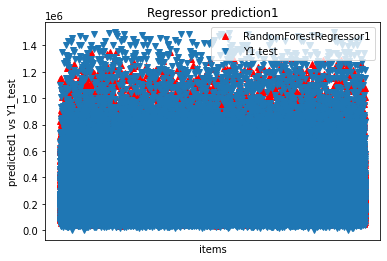

In [73]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

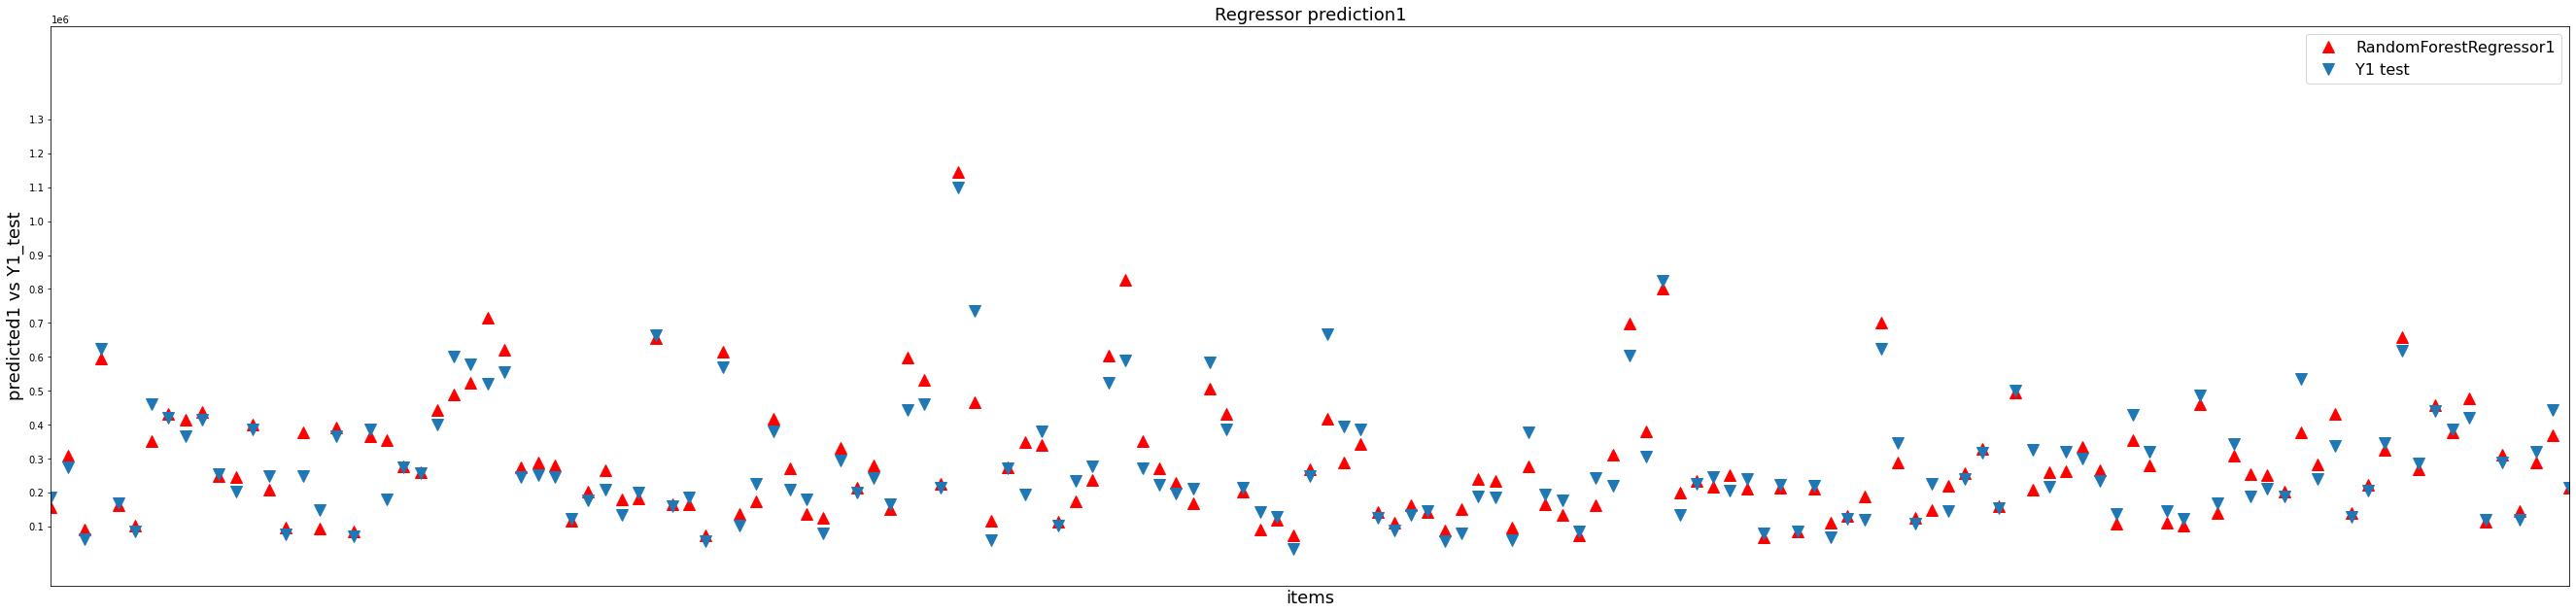

In [75]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [76]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [77]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

68530.99473298446

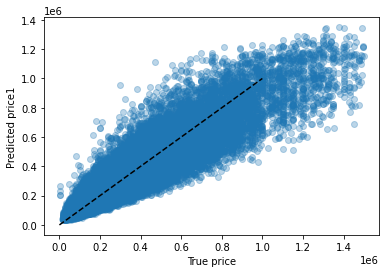

In [78]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()
